# Law, Bias, and Algorithms
## Algorithmic fairness (2/2)

Today, we will continue building and evaluating our own risk assessment tool using the COMPAS data to examine some other aspects of fairness.

Just to recap what's in the data and what was the model we built:

In [48]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Because huge plots are ugly
options(repr.plot.width = 6, repr.plot.height = 4)

# Read the data
compas_df <- read_rds("../data/compas.rds")

# Recap the model
recid_model <- glm(is_recid ~ priors_count + age, data = compas_df, family = "binomial")
compas_df <- compas_df %>%
    mutate(
        risk = predict(recid_model, type = "response"),
        predicted_risk_score = round(risk * 10),
        pred_recid = risk >= 0.5
    )

## COMPAS data revisited

A cleaned version of the COMPAS data is loaded as `compas_df`, with the following columns

* `id`: unique identifiers for each case
* `sex`, `dob`, `age`, `race`: demographic information for each defendant
* `recid_score`, `violence_score`: COMPAS scores assessing risk that a defendant will recidivate (`violence_score` for violent crimes) within two years of release (higher score correspond to higher risk)
* `priors_count`: number of prior arrests
* `is_recid`, `is_violent_recid`: Indicator variable that is `1` if the defendant was arrested for a new (violent) crime within two years of release, and `0` otherwise.

In [49]:
head(compas_df)

id,sex,dob,age,race,recid_score,violence_score,priors_count,is_recid,is_violent_recid,risk,predicted_risk_score,pred_recid
<dbl>,<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
3,Male,1982-01-22,34,African-American,3,1,0,1,1,0.365,4,FALSE
4,Male,1991-05-14,24,African-American,4,3,4,1,0,0.641,6,TRUE
5,Male,1993-01-21,23,African-American,8,6,1,0,0,0.535,5,TRUE
8,Male,1974-07-23,41,Caucasian,6,2,14,1,0,0.800,8,TRUE
10,Female,1976-06-03,39,Caucasian,1,1,0,0,0,0.311,3,FALSE
13,Male,1994-06-10,21,Caucasian,3,5,1,1,1,0.559,6,TRUE


### Exercise 1: Calibration by gender

Recall that last week we examined how our recidivism prediction model performed for different racial groups, and it turned out our model was well calibrated for white and black defendants.

In our last exercise notebook, we are going to start by examining our model calibration for genders.

We will reuse `predicted_risk_score` we calculated last week. Recall it's a discretized (rounded) version of our predicted risk

For exercise 1, calculate recidivism rates for male and female in our dataset by creating a data frame called `calibration_by_gender` containing three columns: `sex`, `predicted_risk_score`, and `recidivism_rate`.
Additionally, to ensure we have enough number of defendents of each gender in every score bucket, we will limit our maximum score to 8 (i.e., set the risk score to 8 for everyone whose score is greater than 8).

In [50]:
# Calculate discretized risk score
# group people with risk score equal or gretaer than 8

calibration_by_gender <- compas_df %>%
# WRITE CODE HERE
# START solution
    mutate(predicted_risk_score = ifelse(predicted_risk_score >= 8, 8, predicted_risk_score)) %>%
    group_by(sex, predicted_risk_score) %>%
    summarize(
        recidivism_rate = mean(is_recid),
        n = n()
    )
# END solution

# Put the recidivism rates of different races side by side
calibration_by_gender %>%
    spread(sex, recidivism_rate) %>%
    group_by(predicted_risk_score) %>%
    summarize(
        n = sum(n),
        Female = first(na.omit(Female)),
        Male = first(na.omit(Male))
    )

predicted_risk_score,n,Female,Male
<dbl>,<int>,<dbl>,<dbl>
1,127,0.125,0.158
2,519,0.164,0.237
3,690,0.247,0.309
4,943,0.312,0.395
5,1727,0.363,0.486
6,1025,0.632,0.683
7,505,0.759,0.767
8,614,0.789,0.820


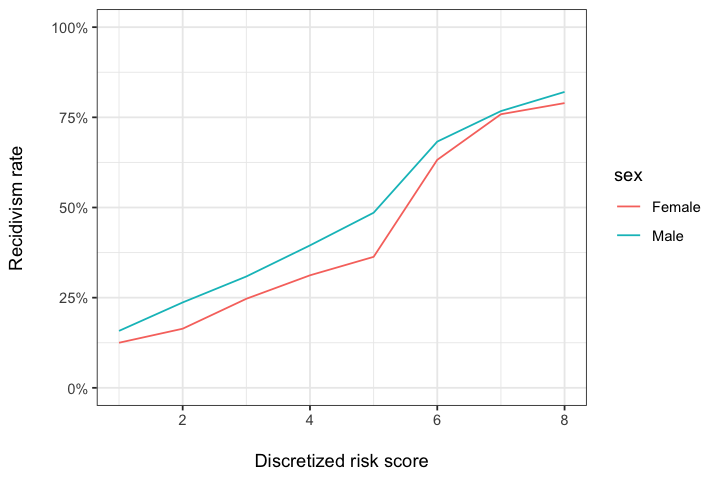

In [51]:
# Calibration plot
ggplot(calibration_by_gender, 
       aes(x = predicted_risk_score, y = recidivism_rate, color = sex)) +
    geom_line() + 
    scale_y_continuous(labels = scales::percent_format(1), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 8, 2), limits = c(1, 8))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

### Exercise 2: Relibrate the model by including gender

We observe roughly 1-point difference for male and female risk scores from the plot above.
To remove this difference, we can calibrate our model by including gender (`sex`) as part of it.

In this exercise, build a gender-aware ricidivism pediction model with `priors_count`, `age`, `sex` and add two columns `gender_aware_risk` and `gender_aware_risk_score` to the data frame.

In [52]:
# Refit the model by including gender

# WRITE CODE HERE
# START solution
recid_gender_model <- glm(is_recid ~ priors_count + age + sex, data = compas_df, family = "binomial")
compas_df <- compas_df %>%
    mutate(
        gender_aware_risk = predict(recid_gender_model, type = "response"),
        gender_aware_risk_score = round(gender_aware_risk * 10)
    )
# END solution

In [53]:
calibration_by_gender <- compas_df %>%
    mutate(gender_aware_risk_score = ifelse(gender_aware_risk_score >= 8, 8, gender_aware_risk_score)) %>%
    group_by(sex, gender_aware_risk_score) %>%
    summarize(recidivism_rate = mean(is_recid))

# Put the recidivism rates of different races side by side
calibration_by_gender %>%
    spread(sex, recidivism_rate)

gender_aware_risk_score,Female,Male
<dbl>,<dbl>,<dbl>
1,0.164,0.155
2,0.235,0.232
3,0.262,0.310
4,0.340,0.373
5,0.550,0.447
6,0.754,0.658
7,0.789,0.750
8,0.794,0.821



Call:
glm(formula = is_recid ~ priors_count + age + sex, family = "binomial", 
    data = compas_df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.113  -1.068  -0.431   1.067   2.238  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.79305    0.10227    7.75  8.9e-15 ***
priors_count  0.15836    0.00736   21.53  < 2e-16 ***
age          -0.04802    0.00256  -18.79  < 2e-16 ***
sexMale       0.37449    0.06954    5.39  7.2e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8525.6  on 6149  degrees of freedom
Residual deviance: 7582.5  on 6146  degrees of freedom
AIC: 7590

Number of Fisher Scoring iterations: 4


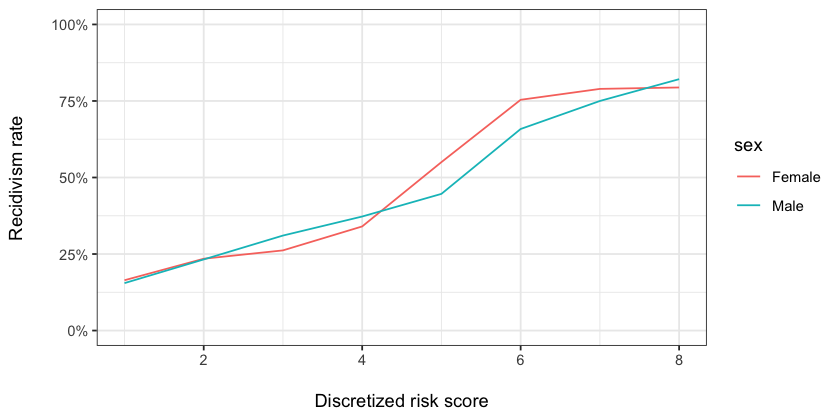

In [59]:
# Show model coeffients
# Male as a covariate increases the model's predicted probability of recidivism
summary(recid_gender_model)

# Calibration plot
ggplot(calibration_by_gender, 
       aes(x = gender_aware_risk_score, y = recidivism_rate, color = sex)) +
    geom_line() + 
    scale_y_continuous(labels = scales::percent_format(1), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 8, 2), limits = c(1, 8))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

### Exercise 3: Compare gender-aware and gender-blind models

Now, let's compare our gender-aware and gender-blind models by examining the number of female defendants detained with a detention risk threshold of $50\%$.
Additionally, let's also compare models' accuracy to see if calibrating our model results in worse model performance.

In [66]:
# Calculate number of females detained and model accuracy for gender-aware and gender-blind models

# WRITE CODE HERE
# START solution
compas_df %>%
    mutate(
        detained = risk > 0.5,
        gender_aware_detained = gender_aware_risk > 0.5
    ) %>%
    summarize(
        n_female_detained = sum(detained & (sex == "Female")),
        acc = mean(detained == is_recid),
        n_female_gender_aware_detained = sum(gender_aware_detained & (sex == "Female")),
        acc_gender_aware = mean(gender_aware_detained == is_recid)
    )
# END solution

n_female_detained,acc,n_female_gender_aware_detained,acc_gender_aware
<int>,<dbl>,<int>,<dbl>
473,0.675,220,0.671


By including gender in our model, we are able to obtain a calibrated model with roughly the same accuracy and few number of women detained.
However, we did explicitly used gender in our gender-aware model and violated anti-classification. Are we satisfied by this approach?

### Exercise 4: False positive rate and false negative rate

We now introduce _false positive rate (FPR)_ and _false negative rate (FNR)_, two common metrics for evaluating model performance.

Before we talk about their definitions, we define the following terms:

* P: the number of real positive cases in the data
* N: the number of real negative cases in the data
* TP: true positives; the number of predicted positive cases that were real positives 
* TN: true negatives; the number of predicted negative cases that were real negatives 
* FP: false positives; the number of predicted positives that were actually negative in the data (false alarms, Type I error)
* FN: false negatives; the number of predicted negatives that were actually positive in the data (Type II error) 

Their definitions can be illustrated using following table:


| <div></div> | Real positive | Real negative |
|--------------------|---------------|---------------|
| Predicted positive |       TP      |            FP |
| Predicted negative |       FN      |            TN |


The the false positive rate (FPR) is given by: 

\begin{equation}
  FPR = \frac{FP}{N} = \frac{FP}{FP + TN}
\end{equation}

Similarly, the false negative rate (FNR) is given by: 

\begin{equation}
  FNR = \frac{FN}{P} = \frac{FN}{TP + FN}
\end{equation}

Coming back to the race disparity we observed last week, in this exercise, let's calculate our model's FPR and FNR for white and black defendants respectively.

In [56]:
# Complete function calc_fpr_fnr to calculate FPR and FNR for races

calc_fpr_fnr <- function(df) {
# WRITE CODE HERE
# START solution
    df %>%
        group_by(race) %>%
        summarize(
            fp = sum((is_recid == 0) & (pred_recid)),
            fn = sum((is_recid == 1) & (!pred_recid)),
            positives = sum(is_recid),
            negatives = sum(!is_recid),
            fpr = fp/negatives,
            fnr = fn/positives
        ) %>%
        select(race, fpr, fnr)
# END solution
}

calc_fpr_fnr(compas_df)

race,fpr,fnr
<chr>,<dbl>,<dbl>
African-American,0.413,0.240
Caucasian,0.228,0.487


### Exercise 5: Equalizing false positive rates

Typically, the lower FPR and FNR are, the better the model performs.
When we try to build a fair model, it's natural to consider building a model that will yield classification results with equal FPR (or FNR) for different groups.

For our recidivism prediction model, one way to do that is to set different thresholds for white defendants and black defendants.
To do so, we will fix our classification threshold for white defendants at $50\%$ and tune the threshold for black defendants so that the false positive rates are equal for both groups.

race,fpr,fnr
<chr>,<dbl>,<dbl>
African-American,0.228,0.414
Caucasian,0.228,0.487


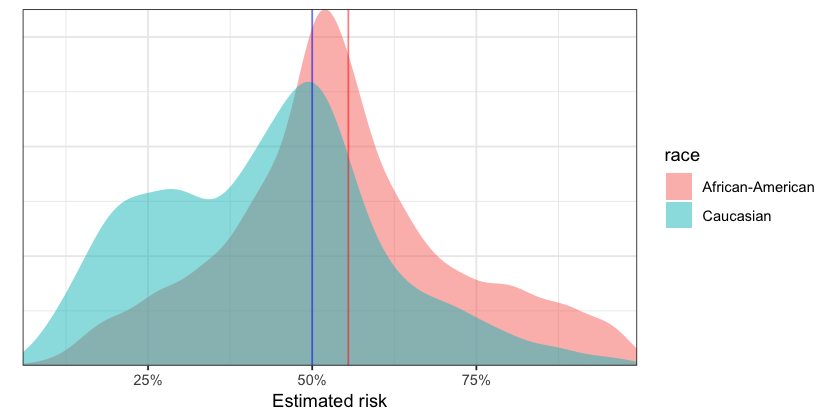

In [57]:
black_threshold = 0.5
white_threshold = 0.5

# WRITE CODE HERE
# START solution
black_threshold = 0.555
# END solution

# Calculate detention and recidivism rate by race
compas_df %>%
    mutate(pred_recid = risk > if_else(race == "Caucasian", white_threshold, black_threshold)) %>%
    calc_fpr_fnr()

# See where the thresholds are on the risk distribution
options(repr.plot.width = 7, repr.plot.height = 3.5)

# Recall this risk distribution plot
# Now we add our thresholds in the plots
ggplot(compas_df, aes(x = risk, fill = race)) +
    geom_density(alpha = 0.5, color = NA) +
    scale_x_continuous("Estimated risk", labels = scales::percent_format(1), expand = c(0, 0)) +
    scale_y_continuous(element_blank(), expand = c(0, 0)) +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank())+
    geom_vline(
        xintercept = c(black_threshold, white_threshold), 
        color = c("red", "blue"),
        alpha = 0.5
    )

In the last exercise,
in order to equalze the false positive rates for both groups,
we end up having to apply different classification thresholds, which may eventually lead to policy decisions, to different racial groups.

Do you think having a model that "performs equally well" for different groups can be considered "fair"?
If not, what are some possible alternative approaches?